### Deriving radiometry from multispectral UAS imagery
This script should be run for each station

This script pulls in aligned, stacked tifs (run Create_aligned_stacked_tifs.ipynb beforehand) and calculates mean sky radiance (Lsky), total radiance (Lt), downwelling irradiance (Ed), and total reflectance (Trs).

It uses a filtering procedure to mask specular sun glint and the boat when present in the images. 

Four methods to remove surface reflected light are applied to derive Rrs, which is compared to in situ Rrs data collected by hyperspectral TriOS radiometers. 

Tifs are georeferenced and exported

Water quality algorithms are applied to Rrs and exported 


In [1]:
from micasense import imageset as imageset
from micasense import capture as capture
from micasense import image as image
import micasense.metadata as metadata
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import exiftool
import datetime
import subprocess
import pandas as pd
import rasterio
import copy
import xarray as xr

### Read in spreadsheet of station data 

***Must change 'i=' to run script on each station***

In [27]:
station_data = pd.read_excel(os.path.join('F:/', 'Micasense_WQ', 'station_data.xlsx'), index_col=False)
i=0

date = station_data['Date'][i]
station = station_data['Site'][i]
mica_dir = station_data['MicaSense dir'][i]
imagePath = os.path.join('F:/', 'Micasense_WQ', date, mica_dir , '000')
wind_idx = np.int(station_data['Wind idx'][i])
cloud_idx = np.int(station_data['Cloud idx'][i])
print(station)
print(imagePath)

CB4.2E
F:/Micasense_WQ\09_16_20\0000SET\000


### Declare time, elevation angle, zenith angle from MicaSense metadata

In [12]:
#load zenith angle from the log file of all flight_stacks derived from Create_aligned_tifs.ipynb
metadata = pd.read_csv(os.path.join(imagePath, 'flight_stacks', 'log.csv'), index_col=False)
time = metadata['GPSTimeStamp'][15] # UTC time at middle capture
print("UTC Time:", time)
mica_elevationangle = (metadata['SolarElevation'].mean())*180/np.pi
print("Solar elevation angle:", mica_elevationangle)
mica_zenith = 90-mica_elevationangle
print("Solar zenith angle:", mica_zenith)
zenith_range = (0, 10, 20, 30, 40, 50, 60)
zenith_idx = (np.abs(zenith_range-mica_zenith)).argmin()

#print LUT indices for zenith angle, wind, and cloud parameters
print("Zenith angle index:",zenith_idx, "Wind index:", wind_idx, "Cloud cover index:", cloud_idx)

UTC Time: 16:38:13
Solar elevation angle: 53.29935222133528
Solar zenith angle: 36.70064777866472
Zenith angle index: 4 Wind index: 1.0 Cloud cover index: 0.0


### Derive mean Lsky radiance for each band

Lsky was collected by taking several image captures with the MicaSense of the sky at an angle away from the sun

C:\Users\Anna\Anaconda3\envs\micasense\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[105.80492159  92.84680295  65.90189121  51.72029067  35.14568252]


Text(0.5, 1.0, 'Lsky')

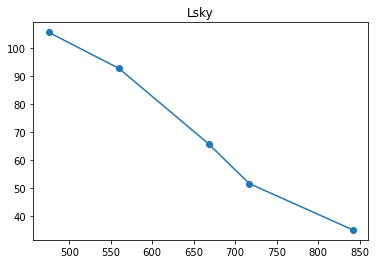

In [16]:
#Declare Lsky and average across stations. Create_aligned_tifs.ipynb was used to create Lsky_stacks tifs
Lsky = []
for im in glob.glob(os.path.join(imagePath, 'Lsky_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Lsky.append(src.read())
Lsky = np.array(Lsky) / 32768 * 1000 # Scale to Radiance (mW)

# Average Lsky Spectra
Lsky_mean = np.mean(Lsky, axis=(0,2,3))
Lsky_sd = np.std(Lsky, axis=(0,2,3))
print(Lsky_mean)

#plot Lsky spectra
wv = [475, 560, 668, 717, 842]
plt.plot(wv, Lsky_mean,  marker = 'o')
plt.title('Lsky')

### Derive mean Ed values for each band

Ed was collected from the DLS during every image capture while in flight

[1092.01547817 1000.75122117  881.50146617  683.33450236  547.974948  ]
(30, 5)


Text(0.5, 1.0, 'Flight Ed')

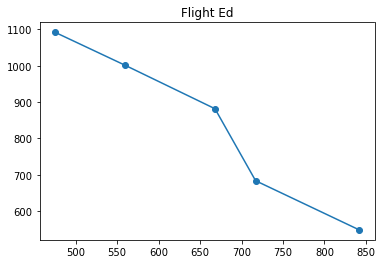

In [14]:
#pull in Ed csv (from Create_aligned_tifs.ipynb) and average across stations
all_Ed = pd.read_csv(os.path.join(imagePath, 'Ed_data.csv')).drop('timestamp', axis=1).to_numpy()
Ed_mean =  np.mean(all_Ed, axis=0)
Ed_sd =  np.std(all_Ed, axis=0)
print(Ed_mean)
print(all_Ed.shape)

#plot Ed spectra
plt.plot(wv, Ed_mean,  marker = 'o')
plt.title('Flight Ed')

### Derive mean Lt for flight captures

Lt was collected with the MicaSense during flight. Thirty images with the highest flight altitude were used in Create_aligned_tifs.ipynb to create flight_stacks tifs

C:\Users\Anna\Anaconda3\envs\micasense\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(30, 5, 923, 1219)
(923, 1219, 30, 5)
[ 9.19845884 11.58385932  6.91360471  4.95143365  3.1913571 ]


Text(0.5, 1.0, 'Flight Lt')

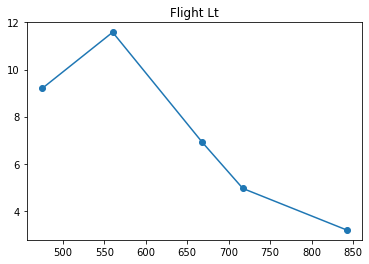

In [17]:
#Decalre Lt and average across stations
Lt = []
for im in glob.glob(os.path.join(imagePath,'flight_stacks')+ "/*.tif"):
    with rasterio.open(im, 'r') as src:
        Lt.append(src.read())        
Lt = np.array(Lt) / 32768 * 1000 # Scale to Radiance (mW)
print(Lt.shape)

# Need to reorder Lt axis so we can divide by all_Ed
# for np.divide to properly 'broadcast' https://numpy.org/doc/stable/user/basics.broadcasting.html
Lt = np.moveaxis(Lt, 0, -1)
Lt = np.moveaxis(Lt, 0, -1)
print(Lt.shape)

Lt_mean =  np.mean(Lt, axis=(0,1,2))
Lt_sd =  np.std(Lt, axis=(0,1,2))
print(Lt_mean)

#plot Lt spectra
plt.plot(wv, Lt_mean,  marker = 'o')
plt.title('Flight Lt')

### Get rho LUT values for zenith, wind, and cloud parameters
A rho LUT was created using simulated values from HydroLight radiative transfer model 

(5, 6, 6, 7)
[0.02312573 0.02314093 0.02316027 0.02316909 0.02319064]
[0.99720086 0.99785636 0.99869033 0.99907075 1.        ]


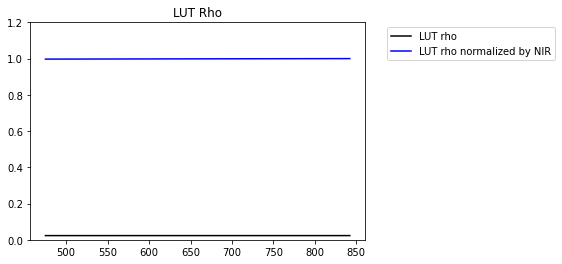

In [29]:
#pull in rho LUT
rho_lut = xr.open_dataarray("F:/MicaSense_WQ/R/rho_lut3.nc")
print(rho_lut.shape) #wv, cloud, wind, zenith 

#Declare rho based on cloud, wind, zenith angle 
lut_rho = rho_lut[:, cloud_idx, wind_idx, zenith_idx].values
print(lut_rho)

#plot rho spectra
plt.plot(wv, lut_rho, color='black', label = 'LUT rho')
plt.title("LUT Rho")


#normalize by nir band 
lut_rho_norm = lut_rho/lut_rho[4,]
print(lut_rho_norm)
plt.plot(wv, lut_rho_norm, color='blue', label = 'LUT rho normalized by NIR')
plt.ylim(0,1.2)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


### Calculate Total Rrs (Trs)

Trs = Lt/Ed. In the paper, this is called Ruas

(923, 1219, 30, 5)
[0.00840803 0.01156048 0.00782782 0.00722762 0.00580827]


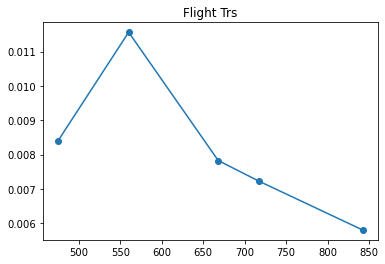

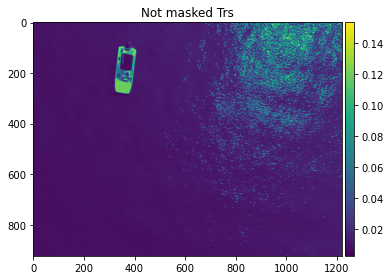

In [31]:
#calculate Trs (Lt/Ed) without masking sun glint
Trs_unmasked = np.divide(Lt, all_Ed)
print(Trs_unmasked.shape)

Trs_unmasked_mean =  np.mean(Trs_unmasked, axis=(0,1,2))
Trs_unmasked_sd =  np.std(Trs_unmasked, axis=(0,1,2))
print(Trs_unmasked_mean)

#plot R spectra
plt.plot(wv, Trs_unmasked_mean,  marker = 'o')
plt.title('Flight Trs')

#plotting example image of R
fig, axis = plotutils.plotwithcolorbar(Trs_unmasked[:,:,5,1], title='Not masked Trs') #5th image
#fig.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','not_masked_example.tif'), dpi=300, format="tiff")

### Mask Trs to remove specular sun glint and boat when present in images

Calculated empirical upper limit using in situ Rrs(NIR) and HydroLight derived rho(NIR) and Lsky/Ed(NIR) values <br>
Used empirical lower limit using Trs(green) to remove dark canopy on boat

0.014151026915886857
[0.0075265  0.0104597  0.00666785 0.00596835 0.00438862]


<Figure size 432x288 with 0 Axes>

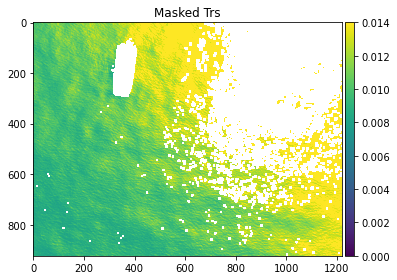

In [33]:
#calculate Trs (Lt/Ed)
Trs_masked = np.divide(Lt, all_Ed)

#calculate upper limit based on known Rrs(NIR), rho(NIR) (from LUT), and Lsky/Ed(NIR) (from HydroLight)
upper = 0.005 + lut_rho[4] * 0.3946
print(upper)

Trs_masked[:,:,:,4][Trs_masked[:,:,:,4]>upper] = np.nan
Trs_masked[:,:,:,1][Trs_masked[:,:,:,1]<0.007] = np.nan #masking boat canopy
nan_index = np.isnan(Trs_masked)

#mask pixels in all bands according to nan_index
for i in range(5):
    Trs_masked[:,:,:,i][nan_index[:,:,:,4]] = np.nan
    Trs_masked[:,:,:,i][nan_index[:,:,:,1]] = np.nan

Trs_masked_mean =  np.nanmean(Trs_masked, axis=(0,1,2))
Trs_masked_sd =  np.nanstd(Trs_masked, axis=(0,1,2))
print(Trs_masked_mean)
    
#plotting example image of masked R
plt.figure(1)
fig, axis = plotutils.plotwithcolorbar(Trs_masked[:,:,5,1], title='Masked Trs', vmin=0, vmax=.014)
#fig.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','masked_example.tif') , dpi=300, format="tiff")


## The following code calculates Rrs using four methods:
1) rhoLUT <br>
2) NIR=0 (dark pixel asusumption) <br>
3) NIR>0 (baseline dark pixel assumption) <br>
4) 'deglinting' (From Hochberg et al. (2003) & Hedley et al. (2005)) <br>

*Each method is run using unmasked and masked Trs*

### 1) Rrs calculated using rho LUT ('pLUT')

Rrs was calculating using rho values from the HydroLight derived rho lookup table. 

[0.00615916 0.0094079  0.00609338 0.00547149 0.00432041]
[0.00527645 0.00830631 0.00493285 0.00421154 0.00290035]


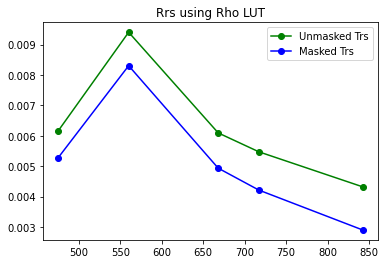

In [34]:
#using unmasked Trs
Rrs_rhoLUT_unmasked = []
for i in range(5):
    Rrs_rhoLUT_unmasked = Trs_unmasked - lut_rho[i] * Lsky_mean/all_Ed 

Rrs_rhoLUT_unmasked_mean = np.nanmean(Rrs_rhoLUT_unmasked, axis=(0,1,2))
Rrs_rhoLUT_unmasked_sd = np.nanstd(Rrs_rhoLUT_unmasked, axis=(0,1,2))
print(Rrs_rhoLUT_unmasked_mean)

#using masked Trs
Rrs_rhoLUT_masked = []
for i in range(5):
    Rrs_rhoLUT_masked = Trs_masked - lut_rho[i] * Lsky_mean/all_Ed 

Rrs_rhoLUT_masked_mean = np.nanmean(Rrs_rhoLUT_masked, axis=(0,1,2))
Rrs_rhoLUT_masked_sd = np.nanstd(Rrs_rhoLUT_masked, axis=(0,1,2))
print(Rrs_rhoLUT_masked_mean)

#plot masked Rrs (can change masking threshold)
plt.plot(wv, Rrs_rhoLUT_unmasked_mean,  marker = 'o', color='green', label = 'Unmasked Trs')
plt.plot(wv, Rrs_rhoLUT_masked_mean,  marker = 'o', color='blue', label = 'Masked Trs')
plt.legend()
plt.title('Rrs using Rho LUT')

#fig, axis = plotutils.plotwithcolorbar(Rrs_rhoLUT_masked[:,:,5,1], title='', vmin=0, vmax=.015)
#fig.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','Rrs_LUTrho.tif') , dpi=300, format="tiff")

del Rrs_rhoLUT_unmasked #, Rrs_rhoLUT_masked


### 2) Rrs calculated with dark pixel assumption ('NIR=0')

Rrs was calculated assumping Rrs(NIR) = 0 (dark pixel assumption)

[-3.47634837e-04  3.16569028e-03  1.05956302e-03  3.79695382e-04
  9.31769060e-21]
[8.96794724e-04 4.11168476e-03 1.55228963e-03 7.89585283e-04
 9.09556252e-21]


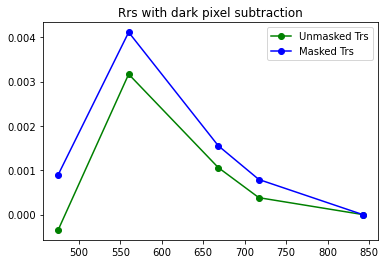

In [35]:
#a dark pixel would have a nir rho value = Lt/Lsky
darkpixel_rho = Lt[:,:,:,4]/Lsky_mean[4]

#create an array with 5 dimensions having same rho values
darkpixel_rho_array = np.concatenate((darkpixel_rho[:,:,:,np.newaxis], darkpixel_rho[:,:,:,np.newaxis], darkpixel_rho[:,:,:,np.newaxis], \
                      darkpixel_rho[:,:,:,np.newaxis], darkpixel_rho[:,:,:,np.newaxis]), axis=3)

#using unmasked Trs
Rrs_darkpixel_unmasked = Trs_unmasked - darkpixel_rho_array*Lsky_mean/all_Ed
Rrs_darkpixel_unmasked_mean = np.nanmean(Rrs_darkpixel_unmasked, axis=(0,1,2))
Rrs_darkpixel_unmasked_sd = np.nanstd(Rrs_darkpixel_unmasked, axis=(0,1,2))

print(Rrs_darkpixel_unmasked_mean)

#using masked Trs
Rrs_darkpixel_masked = Trs_masked - darkpixel_rho_array*Lsky_mean/all_Ed
Rrs_darkpixel_masked_mean = np.nanmean(Rrs_darkpixel_masked, axis=(0,1,2))
Rrs_darkpixel_masked_sd = np.nanstd(Rrs_darkpixel_masked, axis=(0,1,2))
print(Rrs_darkpixel_masked_mean)

#plot Rrs 
plt.plot(wv, Rrs_darkpixel_unmasked_mean,  marker = 'o', color='green', label = 'Unmasked Trs')
plt.plot(wv, Rrs_darkpixel_masked_mean,  marker = 'o', color='blue', label = 'Masked Trs')
plt.legend()
plt.title('Rrs with dark pixel subtraction')
del Lt, Rrs_darkpixel_unmasked #, Rrs_darkpixel_masked

### 3) Rrs calculated with baseline Rrs(NIR) ('NIR>0')
Rrs is calculated using a basline Rrs(NIR) value derived from a nonlinear model relating in situ Rrs(NIR) and Trs(blue/rededge)

0.0001978797696543422
0.08771302478258763
[-4.90054298e-05  3.45182174e-03  1.29019241e-03  6.13104751e-04
  1.97879770e-04]
0.00016702827034189183
0.0658507193510255
[0.00114917 0.00435331 0.00174699 0.0009867  0.00016703]


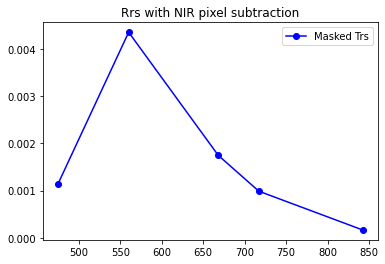

In [36]:
#using unmasked Trs
#exp function from R
blue_re_ratio = Trs_unmasked[:,:,:,0]/Trs_unmasked[:,:,:,3]
blue_re_ratio[blue_re_ratio == 0] = 'nan' #setting 0 to nans because was getting divide by 0 error
#print(np.nanmean(blue_re_ratio))
nir_predict = 0.02564*np.exp(blue_re_ratio * -5.469) + 0.00013
print(np.nanmean(nir_predict))

rho_predict = (all_Ed[:,4]/Lsky_mean[4]) * (Trs_unmasked[:,:,:,4] - nir_predict)
print(np.nanmean(rho_predict))

#create an array with 5 dimensions having same rho values
nir_pixel_array = np.concatenate((rho_predict[:,:,:,np.newaxis], rho_predict[:,:,:,np.newaxis], rho_predict[:,:,:,np.newaxis], \
                      rho_predict[:,:,:,np.newaxis], rho_predict[:,:,:,np.newaxis]), axis=3)


Rrs_nirpixel_unmasked = Trs_unmasked - nir_pixel_array*Lsky_mean/all_Ed
Rrs_nirpixel_unmasked_mean = np.nanmean(Rrs_nirpixel_unmasked, axis=(0,1,2))
Rrs_nirpixel_unmasked_sd = np.nanstd(Rrs_nirpixel_unmasked, axis=(0,1,2))
print(Rrs_nirpixel_unmasked_mean)


#using masked Trs
blue_re_ratio2 = Trs_masked[:,:,:,0]/Trs_masked[:,:,:,3]
blue_re_ratio2[blue_re_ratio2 == 0] = 'nan' #setting 0 to nans because was getting divide by 0 error
#print(np.nanmean(blue_re_ratio2))
nir_predict2 = 0.02564*np.exp(blue_re_ratio2 * -5.469) + 0.00013
print(np.nanmean(nir_predict2))

rho_predict2 = (all_Ed[:,4]/Lsky_mean[4]) * (Trs_masked[:,:,:,4] - nir_predict2)
print(np.nanmean(rho_predict2))

#create an array with 5 dimensions having same rho values
nir_pixel_array2 = np.concatenate((rho_predict2[:,:,:,np.newaxis], rho_predict2[:,:,:,np.newaxis], rho_predict2[:,:,:,np.newaxis], \
                      rho_predict2[:,:,:,np.newaxis], rho_predict2[:,:,:,np.newaxis]), axis=3)

Rrs_nirpixel_masked = Trs_masked - nir_pixel_array2*Lsky_mean/all_Ed
Rrs_nirpixel_masked_mean = np.nanmean(Rrs_nirpixel_masked, axis=(0,1,2))
Rrs_nirpixel_masked_sd = np.nanstd(Rrs_nirpixel_masked, axis=(0,1,2))
print(Rrs_nirpixel_masked_mean)

#plot Rrs 
#plt.plot(wv, Rrs_nirpixel_unmasked_mean,  marker = 'o', color='green', label = 'Unmasked Trs')
plt.plot(wv, Rrs_nirpixel_masked_mean,  marker = 'o', color='blue', label = 'Masked Trs')
plt.legend()
plt.title('Rrs with NIR pixel subtraction')

del rho_predict, Rrs_nirpixel_unmasked, rho_predict2, #Rrs_nirpixel_masked


### 4) Rrs calcualted by deglinting methods of Hochberg et al. (2003) ('deglinting')

(32485194, 5)
[1.40151998 1.50375024 1.40621297 1.38229368 1.        ]
[0.00406167 0.00674214 0.00319142 0.00255106 0.00191643]


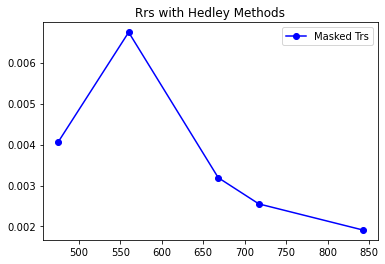

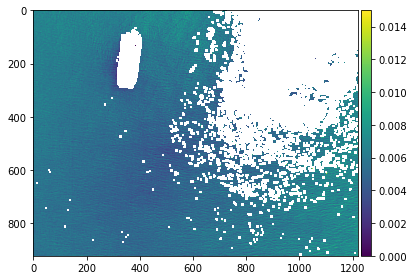

In [38]:
#decalre minimum Trs(NIR) value (doing this before getting rid of nans)
min_Trs_unmasked = np.percentile(Trs_unmasked[:,:,:,4], .1)
min_Trs_masked = np.nanpercentile(Trs_masked[:,:,:,4], .1)
#print(min_Trs_unmasked, min_Trs_masked)

#find the indices of non nans and make array of those
no_nan_idx = np.isfinite(Trs_masked[:,:,:,0])
no_nan_Trs_masked = Trs_masked[no_nan_idx]
print(no_nan_Trs_masked.shape)

#get slopes between NIR and visible bands
blue_m, blue_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,0], 1)
green_m, green_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,1], 1)
red_m, red_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,2], 1)
rededge_m, rededge_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,3], 1)
nir_m, nir_b = np.polyfit(no_nan_Trs_masked[:,4], no_nan_Trs_masked[:,4], 1)
slopes = np.array([blue_m, green_m, red_m, rededge_m, nir_m])
print(slopes)

#using unmasked Trs
Rrs_Hedley_unmasked = np.zeros((923,1219,30,5))
for i in range(5):
    Rrs_Hedley_unmasked[:,:,:,i] = Trs_unmasked[:,:,:,i] - slopes[i]*(Trs_unmasked[:,:,:,4]-min_Trs_unmasked)
Rrs_Hedley_unmasked_mean = np.nanmean(Rrs_Hedley_unmasked, axis=(0,1,2))
Rrs_Hedley_unmasked_sd = np.nanstd(Rrs_Hedley_unmasked, axis=(0,1,2))

#using masked Trs
Rrs_Hedley_masked = np.zeros((923,1219,30,5))
for i in range(5):
    Rrs_Hedley_masked[:,:,:,i] = Trs_masked[:,:,:,i] - slopes[i]*(Trs_masked[:,:,:,4]-min_Trs_masked)
Rrs_Hedley_masked_mean = np.nanmean(Rrs_Hedley_masked, axis=(0,1,2))
Rrs_Hedley_masked_sd = np.nanstd(Rrs_Hedley_masked, axis=(0,1,2))
print(Rrs_Hedley_masked_mean)

#plot Rrs 
#plt.plot(wv, Rrs_Hedley_unmasked_mean,  marker = 'o', color='green', label = 'Unmasked Trs')
plt.plot(wv, Rrs_Hedley_masked_mean,  marker = 'o', color='blue', label = 'Masked Trs')
plt.legend()
plt.title('Rrs with Hedley Methods')

fig, axis = plotutils.plotwithcolorbar(Rrs_Hedley_masked[:,:,5,1], title='', vmin=0, vmax=.015)
#fig.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','Rrs_Hedley.tif') , dpi=300, format="tiff")

del Rrs_Hedley_unmasked, Trs_unmasked #, Rrs_Hedley_masked, Trs_masked 

### 6 panel figure of unmasked/masked Trs and Rrs with different methods to remove surface reflected light

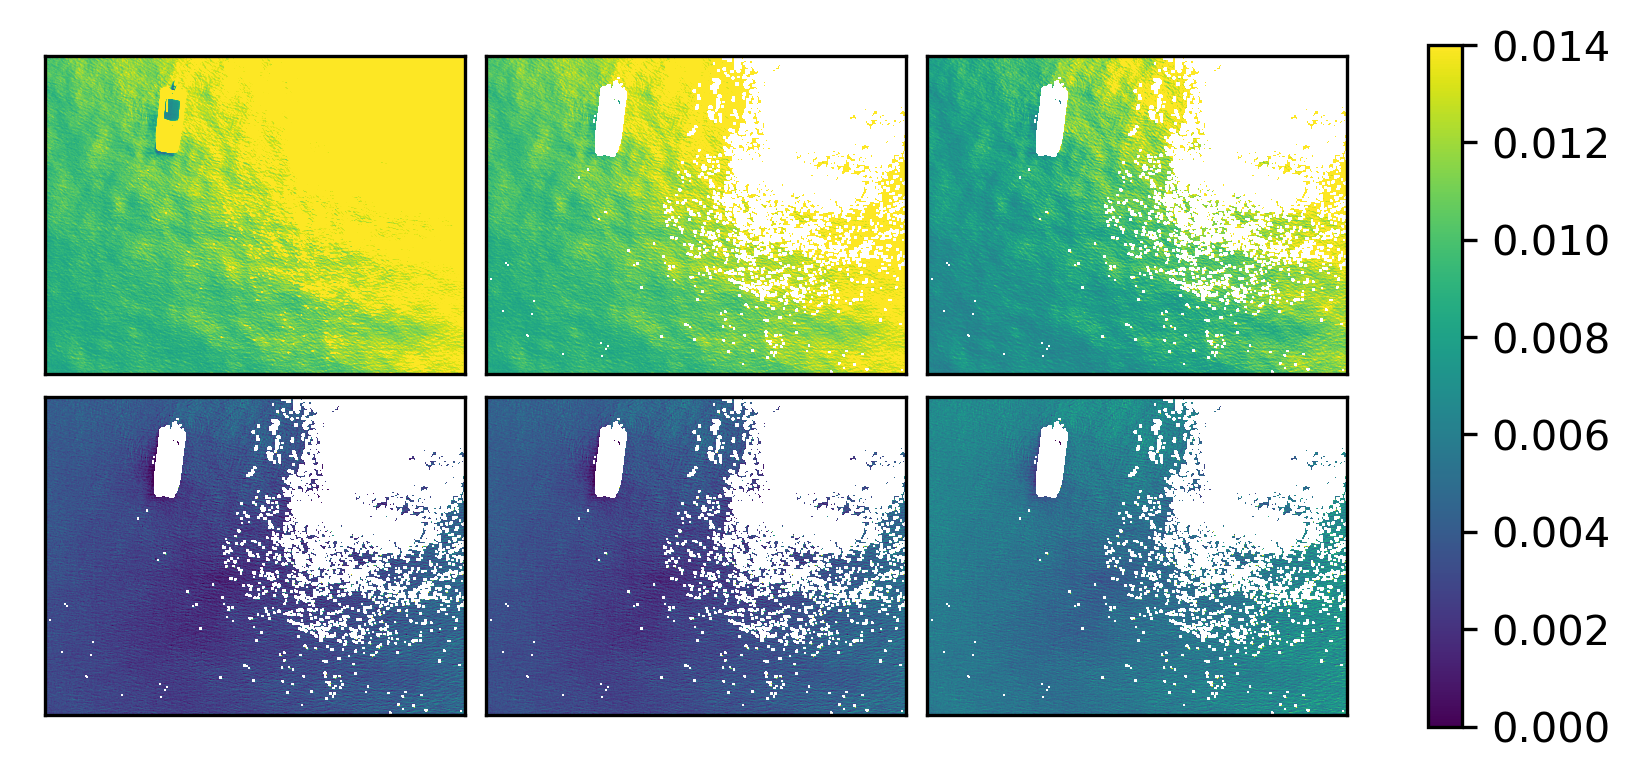

In [25]:
fig, axs = plt.subplots(2,3, sharex='col', sharey ='row', figsize=(7,3.01), dpi=300)
fig.subplots_adjust(wspace=.05, hspace=0)

pos = axs[0,0].imshow(Trs_unmasked[:,:,5,1], vmin= 0, vmax=0.014)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])

axs[0,1].imshow(Trs_masked[:,:,5,1], vmin= 0, vmax=0.014)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])

axs[0,2].imshow(Rrs_rhoLUT_masked[:,:,5,1], vmin= 0, vmax=0.014)
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])

axs[1,0].imshow(Rrs_darkpixel_masked[:,:,5,1], vmin= 0, vmax=0.014)
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

axs[1,1].imshow(Rrs_nirpixel_masked[:,:,5,1], vmin= 0, vmax=0.014)
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])

axs[1,2].imshow(Rrs_Hedley_masked[:,:,5,1], vmin= 0, vmax=0.014)
axs[1,2].set_xticks([])
axs[1,2].set_yticks([])

fig.colorbar(pos, ax=axs)

#plt.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','Rrs_panel.tif') , dpi=300, format="tiff")
#plt.savefig(os.path.join('S:/', 'Micasense_WQ', 'Figures','Rrs_panel.png') , dpi=300, format="png")

### Read in in situ TriOS Rrs data with MicaSense spectral response functions (SRF) applied

(0.049054756326279494, 0.052454595892848274, 0.04723288549692111, 0.04428619597690103, 0.043635455857591536)
(0.0020221176009975225, 0.003975165517322684, 0.0017813431217091754, 0.0007863553287770616, 0.00011563209238730022)


Text(0.5, 1.0, 'Rrs (Trios)')

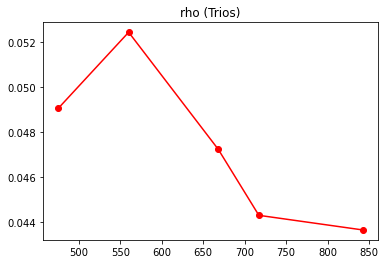

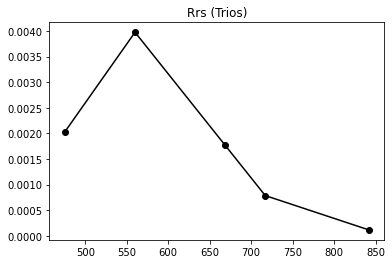

In [39]:
#import trios radiometry spreadsheet as pandas df
df = pd.read_excel('F:/Micasense_WQ/SRF/MicaSense_SRF.xlsx', sheet_name = 'ALL')

#declare rho
trios_SRF_rho = df[['Site', 'Lee Rho (Lt-Lw)/Lsky)']]
index_ = df['WV']
trios_SRF_rho.index = index_

#index rho for specific station
station_rho = trios_SRF_rho['Lee Rho (Lt-Lw)/Lsky)'][trios_SRF_rho['Site'] == station]

blue_rho_trios = station_rho.iloc[0]
green_rho_trios = station_rho.iloc[1]
red_rho_trios = station_rho.iloc[2]
rededge_rho_trios = station_rho.iloc[3]
nir_rho_trios = station_rho.iloc[4]
rho_trios = (blue_rho_trios, green_rho_trios, red_rho_trios, rededge_rho_trios, nir_rho_trios)
print(rho_trios)

#plot TriOS rho spectra
plt.plot(wv, rho_trios,  marker = 'o', color = 'red')
plt.title('rho (Trios)')

#declare Rrs
trios_SRF_Rrs = df[['Site', 'Rrs (Lw/Ed)']]
index_ = df['WV']
trios_SRF_Rrs.index = index_

#index Rrs for specific station
station_Rrs = trios_SRF_Rrs['Rrs (Lw/Ed)'][trios_SRF_Rrs['Site'] == station]

blue_Rrs_trios = station_Rrs.iloc[0]
green_Rrs_trios = station_Rrs.iloc[1]
red_Rrs_trios = station_Rrs.iloc[2]
rededge_Rrs_trios = station_Rrs.iloc[3]
nir_Rrs_trios = station_Rrs.iloc[4]
Rrs_trios = (blue_Rrs_trios, green_Rrs_trios, red_Rrs_trios, rededge_Rrs_trios, nir_Rrs_trios)
print(Rrs_trios)

plt.figure(2)
plt.plot(wv, Rrs_trios,  marker = 'o', color = 'black')
plt.title('Rrs (Trios)')


### Plot all Rrs (unmasked/masked Trs)

Text(0.5, 1.0, 'Rrs with Masked Trs')

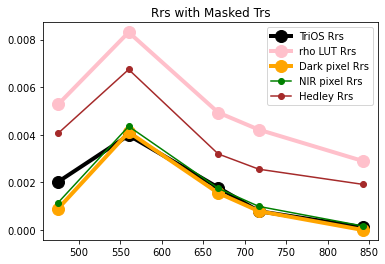

In [43]:
#plot Rrs with unmaked Trs
'''
plt.figure(1)
plt.plot(wv, Rrs_trios, marker='o', markerfacecolor='black', markersize=12, color='black', linewidth=4, label= 'TriOS Rrs')
plt.plot(wv, Rrs_rhoLUT_unmasked_mean,  marker = 'o', color='pink', markersize=12, linewidth=4, label = 'rho LUT Rrs')
plt.plot(wv, Rrs_darkpixel_unmasked_mean,  marker = 'o', color='orange', markersize=12, linewidth=4, label = 'Dark pixel Rrs')
plt.plot(wv, Rrs_darkpixel_norm_unmasked_mean,  marker = 'o', color='red', label = 'Dark pixel Rrs normalized by LUT rho')
plt.plot(wv, Rrs_nirpixel_norm_unmasked_mean,  marker = 'o', color='green', label = 'NIR pixel Rrs')
plt.plot(wv, Rrs_nirpixel_norm_unmasked_mean,  marker = 'o', color='blue', label = 'NIR pixel Rrs normalized by LUT rho')
plt.plot(wv, Rrs_Hedley_unmasked_mean,  marker = 'o', color='brown', label = 'Hedley Rrs')
plt.legend()
plt.title('Rrs with Unmasked Trs')
'''
#plot Rrs with masked trs
plt.figure(2)
plt.plot(wv, Rrs_trios, marker='o', markerfacecolor='black', markersize=12, color='black', linewidth=4, label= 'TriOS Rrs')
plt.plot(wv, Rrs_rhoLUT_masked_mean,  marker = 'o', color='pink', markersize=12, linewidth=4, label = 'rho LUT Rrs')
plt.plot(wv, Rrs_darkpixel_masked_mean,  marker = 'o', color='orange', markersize=12, linewidth=4, label = 'Dark pixel Rrs')
plt.plot(wv, Rrs_nirpixel_masked_mean,  marker = 'o', color='green', label = 'NIR pixel Rrs')
plt.plot(wv, Rrs_Hedley_masked_mean,  marker = 'o', color='brown', label = 'Hedley Rrs')
plt.legend()
plt.title('Rrs with Masked Trs')


In [44]:
d = {'wv': [475, 560, 668, 717, 842], 'Lsky': Lsky_mean, 'Lsky_std': Lsky_sd, \
     'Lt': Lt_mean, 'Lt_std': Lt_sd, 'Ed_mean': Ed_mean, 'Ed_std': Ed_sd, \
     'Trs_unmasked_mean': Trs_unmasked_mean, 'Trs_unmasked_sd': Trs_unmasked_sd, \
     'Trs_masked_mean': Trs_masked_mean, 'Trs_masked_sd': Trs_masked_sd,'Masking_value': upper, \
     'rho_LUT': lut_rho, 'rho_LUT_norm': lut_rho_norm, \
     'Rrs_rhoLUT_unmasked_mean': Rrs_rhoLUT_unmasked_mean, 'Rrs_rhoLUT_masked_mean': Rrs_rhoLUT_masked_mean, \
     'Rrs_rhoLUT_unmasked_sd': Rrs_rhoLUT_unmasked_sd, 'Rrs_rhoLUT_masked_sd': Rrs_rhoLUT_masked_sd, \
     'Rrs_darkpixel_unmasked_mean': Rrs_darkpixel_unmasked_mean, 'Rrs_darkpixel_masked_mean': Rrs_darkpixel_masked_mean, \
     'Rrs_darkpixel_unmasked_sd': Rrs_darkpixel_unmasked_sd, 'Rrs_darkpixel_masked_sd': Rrs_darkpixel_masked_sd, \
     'Rrs_nirpixel_unmasked_mean': Rrs_nirpixel_unmasked_mean, 'Rrs_nirpixel_unmasked_sd': Rrs_nirpixel_unmasked_sd, \
     'Rrs_nirpixel_masked_mean': Rrs_nirpixel_masked_mean, 'Rrs_nirpixel_masked_sd': Rrs_nirpixel_masked_sd, \
     'Rrs_Hedley_unmasked_mean': Rrs_Hedley_unmasked_mean, 'Rrs_Hedley_unmasked_sd': Rrs_Hedley_unmasked_sd, \
     'Rrs_Hedley_masked_mean': Rrs_Hedley_masked_mean, 'Rrs_Hedley_masked_sd': Rrs_Hedley_masked_sd, \
     'Hedley_slopes': slopes, 'NIR_unmasked_min': min_Trs_unmasked, 'NIR_masked_min': min_Trs_masked, \
     'TriOS_Rrs': Rrs_trios, 'TriOS_rho': rho_trios}
     

station_data = pd.DataFrame(d)
print(station_data)
#station_data.to_csv(os.path.join('F:/', 'Micasense_WQ', date, station + '.csv'), index=False, header=True)


    wv        Lsky  Lsky_std         Lt    Lt_std      Ed_mean     Ed_std  \
0  475  105.804922  4.937174   9.198459  7.992725  1092.015478  32.688820   
1  560   92.846803  4.461763  11.583859  9.245962  1000.751221  22.150682   
2  668   65.901891  3.156560   6.913605  7.930721   881.501466  17.805422   
3  717   51.720291  3.235937   4.951434  6.260966   683.334502  15.526765   
4  842   35.145683  3.292323   3.191357  5.044212   547.974948   9.831345   

   Trs_unmasked_mean  Trs_unmasked_sd  Trs_masked_mean  ...  \
0           0.008408         0.007205         0.007526  ...   
1           0.011560         0.009109         0.010460  ...   
2           0.007828         0.008890         0.006668  ...   
3           0.007228         0.009033         0.005968  ...   
4           0.005808         0.009096         0.004389  ...   

   Rrs_nirpixel_masked_sd  Rrs_Hedley_unmasked_mean  Rrs_Hedley_unmasked_sd  \
0                0.002084                  0.002954            9.151620e-03   


### Georeference and export tifs
This code georeferences flight_stacks tifs based on the metadata in the log.csv file for that station

In [20]:
import cameratransform as ct

for n in range(30):
    log = pd.read_csv(os.path.join(imagePath, 'flight_stacks', 'log.csv'), index_col=False)

    focal = log['FocalLength'][n]
    image_size = log['ImageWidth'][n], log['ImageHeight'][n]
    lat = log['GPSLatitude'][n]
    lon = log['GPSLongitude'][n]
    alt = log['GPSAltitude'][n]
    pitch = log['Pitch'][n]
    roll = log['Roll'][n]
    yaw = log['Yaw'][n]

    cam = ct.Camera(ct.RectilinearProjection(focallength_mm=focal,
                                         image=image_size),
                   ct.SpatialOrientation(elevation_m=alt,
                                     tilt_deg=pitch,
                                     roll_deg=roll,
                                    heading_deg=yaw))

    # gps pts are lat lon
    cam.setGPSpos(lat, lon, alt)

    # these are the coordinates of the image corners
    coords = np.array([cam.gpsFromImage([0 , 0]), \
        cam.gpsFromImage([image_size[0]-1 , 0]), \
        cam.gpsFromImage([image_size[0]-1, image_size[1]-1]), \
        cam.gpsFromImage([0 , image_size[1]-1])])

    gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
    gcp2 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
    gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
    gcp4 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)
    #print(gcp1, gcp2, gcp3, gcp4)
 

    # open the original image
    with rasterio.open(os.path.join(imagePath, 'flight_stacks', log['ID'][n]), 'r') as src:
        profile = src.profile
        #print(profile)
                 
        # create rasterio transform
        tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
    
        crs = rasterio.crs.CRS({"init": "epsg:4326"})

        profile.update(dtype=rasterio.uint8, transform = tsfm, crs=crs)

        with rasterio.open(os.path.join(imagePath, 'georeferenced_stacks', log['ID'][n]), 'w', **profile) as dst:
            dst.write(src.read().astype(rasterio.uint8))   


C:\Users\Anna\Anaconda3\envs\micasense\lib\site-packages\rasterio\__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### Apply water quality algorithms
The code below applies chlorophyll and TSS algorithms to Rrs data (best performing Rrs was determined in different analysis)

[[14.12591348 14.80333799 10.58894631 ...         nan         nan
          nan]
 [13.38600908 12.71181901 12.54141286 ...         nan         nan
          nan]
 [10.8508385  15.75996902 10.86519348 ...         nan         nan
          nan]
 ...
 [ 7.3260054   3.54552409  7.24309484 ... 10.23180681  2.63712217
   4.0779495 ]
 [12.83672015  7.97656538  6.83374648 ... -4.59923364  9.96623549
  13.20301693]
 [ 8.92303956  0.9655815   6.5119614  ... -2.31936958  2.27212301
  10.20257352]]


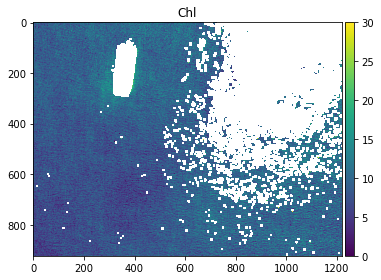

In [45]:
#Apply chl algorithm to Rrs calculated with baseline NIR ('NIR>0')
chl = 24.018 + Rrs_nirpixel_masked[:,:,:,1]*-4337.878 + Rrs_nirpixel_masked[:,:,:,3]*9639.746 + Rrs_nirpixel_masked[:,:,:,4]*-29222.799
print(chl[:,:,5])
fig, axis = plotutils.plotwithcolorbar(chl[:,:,5], title='Chl', vmin=0, vmax=30)

min_chl = np.nanmin(chl)
max_chl = np.nanmax(chl)
mean_chl = np.nanmean(chl)
sd_chl = np.nanstd(chl)

[[31.28618537 37.13239746 39.98077252 ...         nan         nan
          nan]
 [28.41219441 32.31252828 39.16352515 ...         nan         nan
          nan]
 [28.14832982 29.77605617 33.743965   ...         nan         nan
          nan]
 ...
 [30.47234172 31.81517205 35.3735469  ... 30.77701007 36.91030467
  43.85788685]
 [29.58352852 32.5049759  33.82507839 ... 30.81441246 34.77904037
  42.55696743]
 [29.71368667 29.38497011 32.77530545 ... 30.08780255 32.79203266
  41.60510099]]


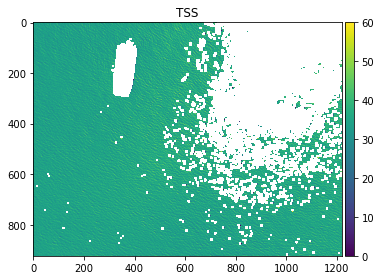

In [46]:
#Apply TSS algorithm to Rrs calculated with deglinting methods ('deglinting')
TSS = 30.56802 + Rrs_Hedley_masked[:,:,:,0]*1364.86038 + Rrs_Hedley_masked[:,:,:,2]*-5255.87676 + Rrs_Hedley_masked[:,:,:,3]*2548.08212 + Rrs_Hedley_masked[:,:,:,4]*4579.36078
print(TSS[:,:,5])
fig, axis = plotutils.plotwithcolorbar(TSS[:,:,5], title='TSS', vmin=0, vmax=60)

min_TSS = np.nanmin(TSS)
max_TSS = np.nanmax(TSS)
mean_TSS = np.nanmean(TSS)
sd_TSS = np.nanstd(TSS)

In [47]:
#saves station min, max, mean, sd chl and TSS data as csv
d = {'min_chl': min_chl, 'max_chl': max_chl, 'mean_chl': mean_chl, 'sd_chl': sd_chl, \
    'min_TSS': min_TSS, 'max_TSS': max_TSS, 'mean_TSS': mean_TSS, 'sd_TSS': sd_TSS}

print(d)

station_data = pd.DataFrame(d, index=[0])
print(station_data)
#station_data.to_csv(os.path.join('F:/', 'Micasense_WQ', date, station + '_chlTSS.csv'), index=False, header=True)


{'min_chl': -605.2640067526089, 'max_chl': 936.9894750995486, 'mean_chl': 9.764401931735543, 'sd_chl': 11.987313632095265, 'min_TSS': -611.0324800227197, 'max_TSS': 446.0095173680935, 'mean_TSS': 34.614245001247916, 'sd_TSS': 13.675991710225157}
      min_chl     max_chl  mean_chl     sd_chl    min_TSS     max_TSS  \
0 -605.264007  936.989475  9.764402  11.987314 -611.03248  446.009517   

    mean_TSS     sd_TSS  
0  34.614245  13.675992  


### Georeference and export chl and TSS tifs

In [ ]:
for n in range(30):
    log = pd.read_csv(os.path.join(imagePath, 'flight_stacks', 'log.csv'), index_col=False)

    # open the original image
    src = rasterio.open(os.path.join(imagePath, "georeferenced_stacks", log['ID'][n]))

    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = src.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=rasterio.float64,
            count=1,
            compress='lzw')

        with rasterio.open(os.path.join(imagePath, "georeferenced_stacks", 'chl_' + log['ID'][n]), 'w', **profile) as dst:
            dst.write(chl[:,:,n].astype(rasterio.float64), 1)
            
        with rasterio.open(os.path.join(imagePath, "georeferenced_stacks", 'TSS_' + log['ID'][n]), 'w', **profile) as dst:
            dst.write(TSS[:,:,n].astype(rasterio.float64), 1)

    # At the end of the ``with rasterio.Env()`` block, context
    # manager exits and all drivers are de-registered.
